In [551]:
# Physics 411 Assignment #2 notebook for questions 1, 2, and 3

# import libraries

import numpy as np
import random as rn
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import scipy as sp
from scipy.stats import norm
import datetime 
import matplotlib.dates as mdates
import random


### Question 1. Linear dependence of wave height and wind speed

Load the data file ”Wind Waveheight.dat” from Brightpace. The file contains data pairs of wind
speed u in m/s (first column) and wave height Hs in metres (second column) observed simultaneously at the same location.
1. Using your preferred software package do the following:
     * Generate a scatter plot of u, Hs. Based on the plot, do you think the data are linearly dependent?
   * Now calculate the correlation coefficient ru Hs. Does it indicate a linear correlation at
     the 95% level?
    * Calculate a linear regression line Hs = a + b u. Give a 95% confidence interval for the
      slope b.
   * Add the regression line Hs = a + b u to the scatter plot.
    * Add to the scatter plot the two regression lines marking the range of regression lines
      accepted at the 95% confidence level.
2. Add an additional data point [u=22 m/s, Hs = 34 m] to the above data set. For the following,
    show your calculations step by step. (You may use a built-in fitting routine).
   * Calculate and plot the regression line for this extended data set.
   *   Using the bootstrap method with 1000 realizations of sub-samples of 50 randomly
       selected data pairs, generate a histogram of the resulting slopes bsubsample
     *   Briefly discuss the results.

In [441]:
# first need to load in a process the data:

wind_wave_data = np.loadtxt("/Users/benrasmussen/Documents/Phys 411/Data/Wind_Waveheight.dat")

wind_data = wind_wave_data.T[0]
wave_data = wind_wave_data.T[1]



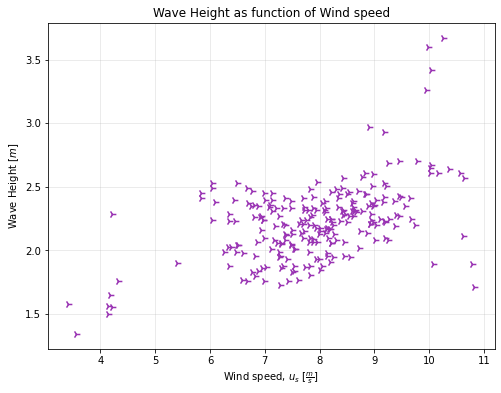

In [442]:
# now need to plot a scatter of the above data:

ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)

# plots wind speed, u, as function of wave height Hs:
ax1.scatter(wind_data,wave_data, s=60,marker="4", color=[0.6,0.2,0.7])
ax1.set_title("Wave Height as function of Wind speed")
ax1.set_xlabel(r"Wind speed, $u_s$ [$\frac{m}{s}$] ")
ax1.set_ylabel(r"Wave Height [$m$]" )
#ax1.set_ylim(-10, 40)
#ax1.set_xlim()
ax1.grid(True, alpha=0.3)

From the above plot, it does seem that the two data sets are somewhat linearly correlated. Apart from a high spread at high wind speeds, the data seems to follow a trend upwards with increasing wind speed. That being said, the trend has a slight bump in it which suggest some non-linearity in the correlation. 

In [443]:
# now need to find the linear correlation coefficient. Will do this two ways, once 
# somewhat explicitly, and the other using the built in python function:

# first with scipy:

cor_coeff = sp.stats.pearsonr(wind_data, wave_data)[0]

# next with slightly more steps:

wind_std = np.std(wind_data, ddof=1)
wave_std = np.std(wave_data, ddof=1)
wave_wind_cov = np.cov(wind_wave_data.T)[0][1]

cor_coeff2 = wave_wind_cov/(wind_std* wave_std)

print(f"The two calculated Coefficients are equal and are: {cor_coeff:0.5f}, {cor_coeff2:0.5f}")

The two calculated Coefficients are equal and are: 0.50432, 0.50432


Now we need to check the linear correlation at a 95% confidence. This can be done by using a 
variable transformation into a standard variable:

$$ w = \frac{1}{2} ln\left(\frac{1+r_{xy}}{1-r_{xy}}\right)$$

This new random variable has a mean and standard deviation as follows:

$$ \mu_w = ln\left(\frac{1+r_{xy}}{1-r_xy}\right), \ \ \ \ \ \sigma_{w} = \left(\frac{1}{N-3}\right)^{\frac{1}{2}}$$

To produce a 95% confidence interval, we then have upper and lower bounds in w of the form:

$$ w_{r_{xy}}(Lower) =\frac{1}{2}ln\left(\frac{1+r_{xy}}{1-r_{xy}}\right) - (w_{1-\alpha/2}/\sqrt{N-3})$$

$$ w_{r_{xy}}(Upper) =\frac{1}{2}ln\left(\frac{1+r_{xy}}{1-r_{xy}}\right) + (w_{1-\alpha/2}/\sqrt{N-3})$$

With $w_{1-\alpha/2}$ just equals to $1.96$.

In [444]:
# we now can implement the above method easily using a function:

def corr_confidence(Rxy, N):
    '''
    Rxy = correlation coefficient
    N = Number of realizations in sample
    '''
    
    #transform:
    w = 1/2 * np.log((1+Rxy)/(1-Rxy))
    #bounds:
    pm = 1.96 / np.sqrt(N-3)
    upper = w + pm
    lower = w - pm
    # now need to transform back to Rxy:
    lower_r = (np.exp(2*lower)-1)/(np.exp(2*lower)+1)
    upper_r = (np.exp(2*upper)-1)/(np.exp(2*upper)+1)
    return [lower_r, upper_r]

# use function:

corr_bounds = corr_confidence(cor_coeff, len(wave_data))

print(f"The bounds on the correlation coefficient are then: {corr_bounds[0]:0.5f} < {cor_coeff:0.5f} < {corr_bounds[1]:0.5f}")



The bounds on the correlation coefficient are then: 0.40434 < 0.50432 < 0.59238


It is clear from the above that the value for $r_{xy}$ is significantly different from zero. This means that a linear correlation at the 95% level is indicated.

In [767]:
# now we need to calculate a linear regression line H = a + bu with a 95% confidence interval 
# for the slope:

def linear_fit(X,Y):
    '''
    X = array of independent values
    Y = array of dependent values
    must have same shape
    '''
    
    # means:
    X_mean = np.mean(X); Y_mean = np.mean(Y)
    
    # slope:
    b_num = sum([(X[i] - X_mean)*(Y[i] - Y_mean) for i in range(len(X))])
    b_denom = sum([(X[i] - X_mean)**2 for i in range(len(X))])
    
    b = b_num / b_denom
    
    # intercept:
    a = Y_mean - b * X_mean
    
    return a,b

# by hand method without gradient descent:

aa,bb = linear_fit(wind_data,wave_data)

print(f"Using a \"by hand\" method for the linear regression, the line H_s = a+ bu is of the form:"
     f"H_s = {aa:0.3f} + {bb:0.3f} * u")

#we can do this using the built in function in scipy, linregress to check work:

ww_regress = sp.stats.linregress(wind_data, wave_data)


print()
print(f"After calculating a linear regression, the line H_s = a+bu is of the form: "  
    f"H_s={ww_regress.intercept:0.3f} + {ww_regress.slope:0.3f} * u Which match as before")
print()

print(f"The standard error in the slope from this regression is: {ww_regress.stderr:0.5f}")

Using a "by hand" method for the linear regression, the line H_s = a+ bu is of the form:H_s = 1.284 + 0.119 * u

After calculating a linear regression, the line H_s = a+bu is of the form: H_s=1.284 + 0.119 * u Which match as before

The standard error in the slope from this regression is: 0.01308


#### For completeness we will calculate the standard error "by hand" as follows:

$$ \delta b = t_{\alpha/2,N} \frac{s_\epsilon}{\sqrt{N-1} s_x}$$

With a standard error of :

$$ s_{\epsilon}=\left(\frac{\Sigma (y_i- \hat{y_i})^2}{N-2}\right)^{1/2}$$

We already know $s_x$ and $\bar{x}$ and $\hat{y}$ is simply the fit evaluated at the specific index of x.

In [446]:
def standard_err(X, Y, a, b, N):
    
    s_x = np.std(X, ddof=1)
    s_e = np.sqrt(1/(N-2) * sum([(Y[i] - (a+b*X[i]))**2 for i in range(len(Y))]))
    error = (s_e/s_x)/(np.sqrt(N-1))
    return error

In [447]:
slope_error = standard_err(wind_data, wave_data, ww_regress.intercept, ww_regress.slope, len(wind_data))

print(f"As expected, the slope error matches the one from the built in and is: {slope_error:0.5f}")



As expected, the slope error matches the one from the built in and is: 0.01308


In [448]:
# To find a confidence interval in this slope, we must look to the student-t distribution.
# Since we have 244 degrees of freedom in the regression we get:

t_alpha = sp.stats.t.ppf(1-0.05/2, len(wave_data)-2)

print(f"The factor of t_a applied to the slope is: {t_alpha:0.4f}")

# this value times the standard error from above will give deviation from mean slope:

err_factor = t_alpha * ww_regress.stderr
upper_slope = ww_regress.slope + err_factor
lower_slope = ww_regress.slope - err_factor

print()
print(f"Thus, the range of slopes within a 95% confidence is: {lower_slope:0.4f} < {ww_regress.slope:0.4f} < {upper_slope:0.4f}")




The factor of t_a applied to the slope is: 1.9698

Thus, the range of slopes within a 95% confidence is: 0.0931 < 0.1188 < 0.1446


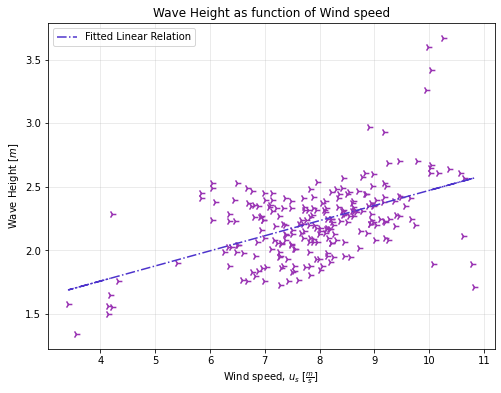

In [449]:
# now we need to impose this slope on top of the original graph:

ff, (ax2) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)

# plots wind speed, u, as function of wave height Hs with fit:

ax2.scatter(wind_data,wave_data, s=60,marker="4", color=[0.6,0.2,0.7], )
ax2.plot(wind_data, ww_regress.slope * wind_data + ww_regress.intercept, '-.',color=[0.3,0.2,0.8], 
         label="Fitted Linear Relation")
ax2.set_title("Wave Height as function of Wind speed")
ax2.set_xlabel(r"Wind speed, $u_s$ [$\frac{m}{s}$] ")
ax2.set_ylabel(r"Wave Height [$m$]" )
ax2.legend()
#ax1.set_ylim(-10, 40)
#ax1.set_xlim()
ax2.grid(True, alpha=0.3)

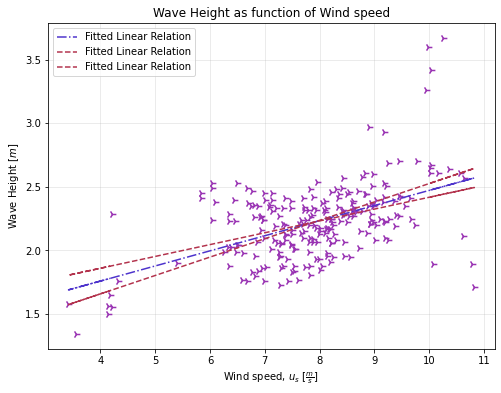

In [450]:
# in order for all fitted lines to pass through the means we must do a bit of algebra:

upper_fit = upper_slope * wind_data + ww_regress.intercept
lower_fit = lower_slope * wind_data + ww_regress.intercept

center = [np.mean(wind_data), np.mean(wave_data)]
differences = [(upper_slope * center[0] + ww_regress.intercept)-center[1]
               ,(lower_slope*center[0] + ww_regress.intercept) -center[1]]

upper_fit = upper_slope * wind_data + ww_regress.intercept - differences[0]
lower_fit = lower_slope * wind_data + ww_regress.intercept - differences[1]


# now we want to add the other two regression lines corresponding to 
# the 95% confidence intervale:

ff, (ax2) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)

# plots wind speed, u, as function of wave height Hs with fit:

#ax2.scatter(np.mean(wind_data), np.mean(wave_data), s=50)
ax2.scatter(wind_data,wave_data, s=60,marker="4", color=[0.6,0.2,0.7], )
ax2.plot(wind_data, ww_regress.slope * wind_data + ww_regress.intercept, '-.',color=[0.3,0.2,0.8], 
         label="Fitted Linear Relation")
ax2.plot(wind_data, upper_fit, '--',color=[0.7,0.2,0.3], 
         label="Fitted Linear Relation")
ax2.plot(wind_data, lower_fit, '--',color=[0.7,0.2,0.3], 
         label="Fitted Linear Relation")
ax2.set_title("Wave Height as function of Wind speed")
ax2.set_xlabel(r"Wind speed, $u_s$ [$\frac{m}{s}$] ")
ax2.set_ylabel(r"Wave Height [$m$]" )
ax2.legend()
#ax1.set_ylim(-10, 40)
#ax1.set_xlim()
ax2.grid(True, alpha=0.3)

New slope is: 0.83362
New intercept is: -4.28527


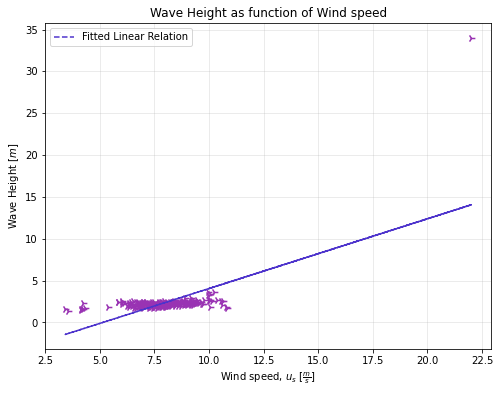

In [451]:
# now we need to add an additional data point [u=22m/s, Hs=34m] to the above data set:

# new point:

wind_data_new = np.append(wind_data, 22)
wave_data_new = np.append(wave_data, 34)

# fit on new data:

new_regress = sp.stats.linregress(wind_data_new, wave_data_new)

print(f"New slope is: {new_regress.slope:0.5f}")
print(f"New intercept is: {new_regress.intercept:0.5f}")
# plots new set of points and fit:
ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)

# plots wind speed, u, as function of wave height Hs:

ax1.plot(wind_data_new, new_regress.slope * wind_data_new + new_regress.intercept, '--',color=[0.3,0.2,0.8], 
         label="Fitted Linear Relation")
ax1.scatter(wind_data_new,wave_data_new, s=60,marker="4", color=[0.6,0.2,0.7])
ax1.set_title("Wave Height as function of Wind speed")
ax1.set_xlabel(r"Wind speed, $u_s$ [$\frac{m}{s}$] ")
ax1.set_ylabel(r"Wave Height [$m$]" )
ax1.legend()
#ax1.set_ylim(-10, 40)
#ax1.set_xlim()
ax1.grid(True, alpha=0.3)

In [452]:
# now we need to implement the bootstrap method to find a histogram of slopes.
# we can do this by creating a generic function as follows:

def bootstrap(X, Y, p=50, N=1000):
    '''
    X = x vector data set
    Y = y vector data set
    p = number of randomly selected data pairs
    N = number of realizations of sub sample
    
    X, Y must be same size
    '''
    # adds to vectors 
    XY = [[X[i], Y[i]] for i in range(len(X))]
    
    # Will do this in a loop:
    
    slopes = []
    
    for i in range(N):
        # first generates a list of 50 different items found in the whole data set:
        sample = random.sample(list(XY),p)
        
        # transposes sample:
        sample_eff = np.array(sample).T
        
        # does a linear regression on this sub sample:
        interim_reg = sp.stats.linregress(sample_eff[0], sample_eff[1])
        
        # finds slope of the fitted sub sample:
        
        b = interim_reg.slope
        slopes.append(b)
        
    return slopes

In [453]:
# gets 1000 slope values from randomly distributed sub samples:
result_slopes = bootstrap(wind_data_new, wave_data_new, 50, 1000)



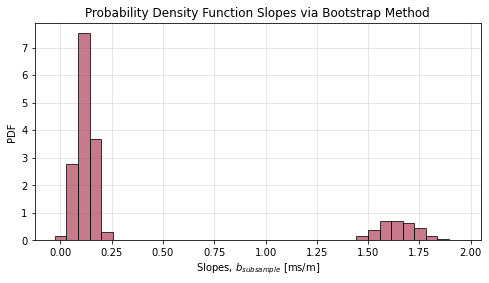

In [454]:
# plots a histogram of the slopes:
plt.rc('axes', axisbelow=True)
ff = plt.figure()
ff.set_figwidth(8)
ff.set_figheight(4)
plt.hist(result_slopes, 35, density=True, facecolor=[0.7,0.3,0.4], alpha=0.75, edgecolor='k')
plt.xlabel(r'Slopes, $b_{subsample}$ [ms/m]')
plt.ylabel('PDF')
plt.title('Probability Density Function Slopes via Bootstrap Method')
#plt.xlim(0.4, 0.6)
#plt.ylim(0, 0.09)
plt.grid(which='both', alpha =0.4)

plt.show()

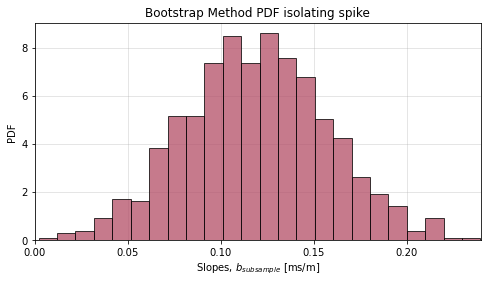

In [455]:
# we can learn even more about the distribution here by zooming in on the large spike:

# plots a histogram of the slopes:
plt.rc('axes', axisbelow=True)
ff = plt.figure()
ff.set_figwidth(8)
ff.set_figheight(4)
plt.hist(result_slopes, 200, density=True, facecolor=[0.7,0.3,0.4], alpha=0.75, edgecolor='k')
plt.xlabel(r'Slopes, $b_{subsample}$ [ms/m]')
plt.ylabel('PDF')
plt.title('Bootstrap Method PDF isolating spike')
plt.xlim(0., 0.24)
#plt.ylim(0, 0.09)
plt.grid(which='both', alpha =0.4)

plt.show()

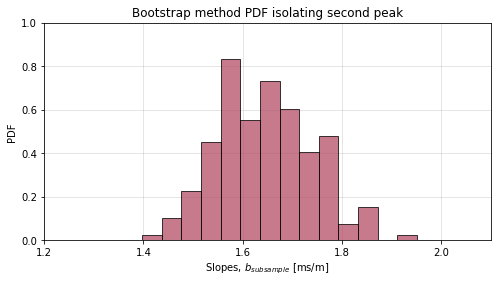

In [456]:
# and eliminating the spike altogether:

# plots a histogram of the slopes:
plt.rc('axes', axisbelow=True)
ff = plt.figure()
ff.set_figwidth(8)
ff.set_figheight(4)
plt.hist(result_slopes, 50, density=True, facecolor=[0.7,0.3,0.4], alpha=0.75, edgecolor='k')
plt.xlabel(r'Slopes, $b_{subsample}$ [ms/m]')
plt.ylabel('PDF')
plt.title('Bootstrap method PDF isolating second peak')
plt.xlim(01.2, 2.1)
plt.ylim(0,1)
plt.grid(which='both', alpha =0.4)

plt.show()

#### Briefly discuss the results:

From the above plots, it is quite clear that the distribution is completely bimodal. We can adequately seperate the probability density function into what appears to be two seperate normal distributions. One of them is a large spike centred at around 0.11, which is what we encountered in the first part of the problem. Isolating the data independent of the spike gives us another roughly normal distribution. Centred at about 1.6, this comes slightly closer to the value found after the additional data point but without the weight of 244 other data points pulling it down. The difference between these distributions is if the random sample includes the massive outlier added later. The tight,normal first distribution is without the outlier and the more spread out second dsitribution is including it. 

## Question 2. Quality of dummy weather forecast
A ”dummy” weather forecast predicts tomorrow’s weather to be the same as today’s. Here you
test if such a ”forecast” has any skill.
Read in the hour-resolution temperature data set for the Station ‘UVicSCI’ (48.462oN, 236.691oE).
For the first part of this exercise look only at data from 1 November 2017 to 31 January 2018, and
for the second part look only at data from 1 June 2020 to 31 August 2020. Show your calculations
step by step (i.e. if you use a pre-defined correlation routine, write down the individual steps how
to calculate rxx(τ ) from discrete data.)
1. For the winter data set:
   * Plot the time series T(t)
   * Calculate the lag correlation coefficient rT T (τ ) for lags τ ≤ 40 days.
   * Plot rT T (τ ).
2. Repeat for the summer data set:
    * Plot the time series T(t)
    * Again, calculate and plot rT T (τ ) for lags τ ≤ 40 days,
   * For both periods, determine the decorrelation time scales, where the envelopes of rT T
     fall below e−1. As envelope you may use a linear fit connecting the local maxima. Here
     you may draw the envelope by hand and read off the approximate τ value.
3. Compare the 2 results for rT T (τ ). Are they different? Why? What can you learn from this
   comparison about local temperature patterns in fall-winter vs. summer.
4. Repeat step 1 and 2 for the hourly pressure data, for the same location:
   * Plot the time series p(t)
   * Calculate the lag correlation coefficient rpp(τ ) for lags τ ≤ 40 days.
   * Plot rpp(τ ).
5. What can you learn from this comparison about the forecast period of a skilled prediction
   of temperature and pressure by a ”dummy forecast”?


In [457]:
# first load in the data:
hourly_temp =np.loadtxt("/Users/benrasmussen/Documents/Phys 411/Data/UVic_weatherdata_temperature_hourly.dat").T
hourly_pressure = np.loadtxt("/Users/benrasmussen/Documents/Phys 411/Data/UVic_weatherdata_pressure_hourly.dat").T

time = hourly_temp[0]
uvic_ht = hourly_temp[14]
uvic_hp = hourly_pressure[14]
# clean up header
uvic_ht = uvic_ht[3:]
uvic_hp = uvic_hp[3:]
time = time[3:]

In [458]:
# now need to seperate into respective seasons by hour:

length_season = 2184 # hrs
time_2_nov17 = 16080 # hrs
time_2_june20 = 38712 # hrs

# seasonal datasets:

winter_t = uvic_ht[time_2_nov17:time_2_nov17+length_season]
winter_p = uvic_hp[time_2_nov17:time_2_nov17+length_season]
winter_time = time[time_2_nov17:time_2_nov17+length_season]
summer_t = uvic_ht[time_2_june20:time_2_june20+length_season]
summer_p = uvic_hp[time_2_june20:time_2_june20+length_season]
summer_time = time[time_2_june20:time_2_june20+length_season]

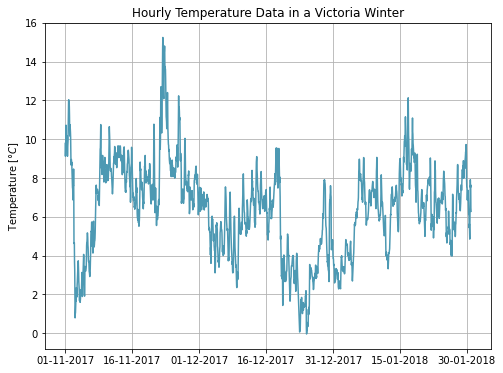

In [460]:
ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)

# plots the hourly data:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax1.plot(winter_test + 16801, winter_t, color=[0.3,0.6,0.7])
ax1.set_title("Hourly Temperature Data in a Victoria Winter")
#ax1.set_xlabel("Random Numbers")
ax1.set_ylabel(r"Temperature [$\degree C$]" )
#ax1.set_ylim(9, 10)
ax1.grid(True)

#### We wish to find the lag correlation coefficient $r_{TT}(\tau)$ for lags $\tau \le 40 days$:

We first begin with the definition of the lag correlation:

$$r_{TT}(\tau) = \frac{C_{TT'}(\tau)}{\sigma_T \sigma_{T'}}$$

Where $C_{TT'}$ is the auto-covariance function and $\sigma_T$, $\sigma_{T'}$ are the standard deviations of the time series and the lagged time series which should be equal. The auto-covariance function is given by:

$$C_{TT}=E[(T_i -\bar{T})(T_{i+k} -\bar{T}] = \frac{1}{N-1} \Sigma_{i=1}^{N-k} ((T_i -\bar{T})(T_{i+k} -\bar{T})$$

In [780]:
# We will now implement the above by creating a function:

def lag_correlation( X, taumax):
    '''
    t = time vector
    X = input time series data set
    tau = maximum lag
    
    '''
    
    # first need the mean of the data set:
    X_mean = np.mean(X)
    
    # also need the variance:
    X_var = (np.std(X, ddof=1))**2
    
    # need a list of desired lags:
    lags = [i for i in range(taumax+1)]
    
    # gotta subtract the mean of the data set from each value for later:
    
    X_sub_mean = [xx - X_mean for xx in X]
    
    # now if we loop through all possible lags and calculate the requisite value 
    # we will have the auto correlation function:
    
    corr_func = len(lags) * [0]
    for lag in lags:
        corr = 1
        
        if (lag >= 1):
            
            auto_cov = [X_sub_mean[lag:][ii]*X_sub_mean[:-lag][ii] for ii in range(len(X)-lag)]
            
            val = sum(auto_cov) / (len(X)-1)
            corr = val/X_var
        corr_func.append(corr)
        
    
    return [lags, corr_func]
    

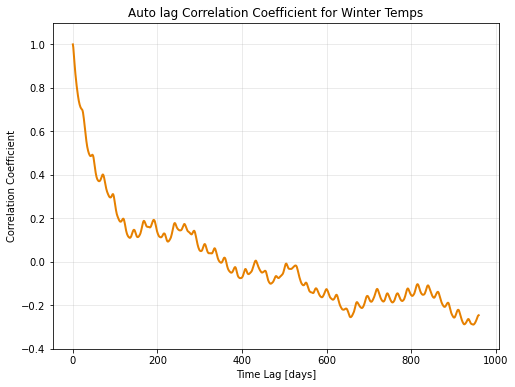

In [790]:
# correlation function for the winter data:
# just plotting positive time lags:

# lags and resulting correlation coefficient:
lag_data_w = lag_correlation(winter_t, 960)
lag_w_eff = lag_data_w[1][961:]
# plots the lag correlation data:
ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)
# just plot positive time lags:
ax1.plot(lag_data_w[0], lag_w_eff,color=[0.9,0.5,0.], linewidth=2)
ax1.set_title("Auto lag Correlation Coefficient for Winter Temps")
ax1.set_xlabel("Time Lag [days]")
ax1.set_ylabel(r"Correlation Coefficient" )
#ax1.set_xlim(16801-60, 16801+60)
ax1.set_ylim(-0.4,1.1)
ax1.grid(True,alpha=0.3)

In [546]:
# will now use built in pandas command to check the above:

import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

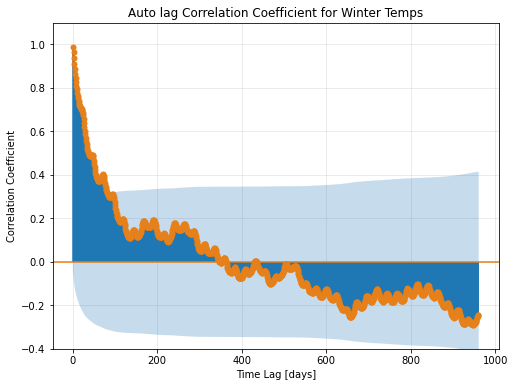

In [786]:
# using pandas we get the following plot:

ff, (ax7) = plt.subplots(nrows=1,ncols=1)
ff.set_figwidth(8)
ff.set_figheight(6)
plot_acf(winter_t, ax=ax7, zero=False, color=[0.9,0.5,0.1], lags=960)
ax7.set_title("Auto lag Correlation Coefficient for Winter Temps")
ax7.set_xlabel("Time Lag [days]")
ax7.set_ylabel(r"Correlation Coefficient" )
#ax7.set_xlim(16801-60, 16801+60)
ax7.set_ylim(-0.4,1.1)
ax7.grid(True,alpha=0.3)

The above trend in the auto lag correlation is nearly identical to the calculated one before. It is then reasonable to proceed with the rest of the analysis using the function that we have built earlier. 

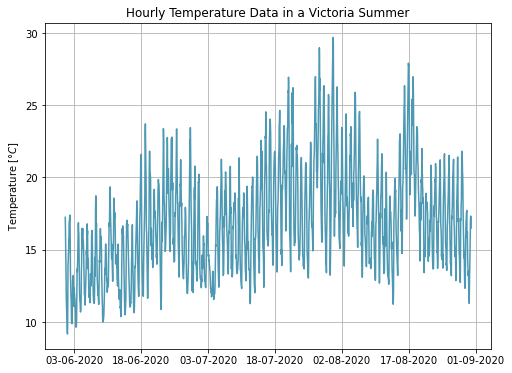

In [595]:
# now we want to repeat the entirety of the above using the summer data set. 
# As everything is already built we can proceed simply:

# plots summer data:
ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)

# plots the hourly data:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax1.plot(summer_time + 16801, summer_t, color=[0.3,0.6,0.7])
ax1.set_title("Hourly Temperature Data in a Victoria Summer")
#ax1.set_xlabel("Random Numbers")
ax1.set_ylabel(r"Temperature [$\degree C$]" )
#ax1.set_ylim(9, 10)
ax1.grid(True)

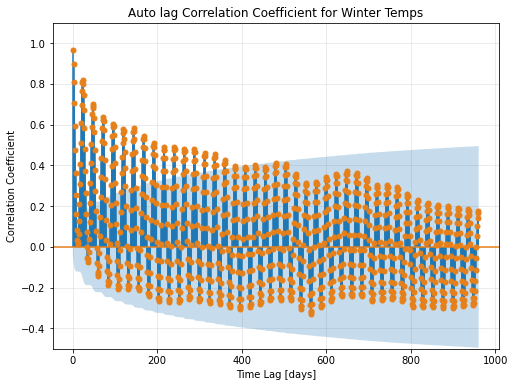

In [792]:
# using pandas we get the following plot:

ff, (ax7) = plt.subplots(nrows=1,ncols=1)
ff.set_figwidth(8)
ff.set_figheight(6)
plot_acf(summer_t, ax=ax7, zero=False, color=[0.9,0.5,0.1], lags=960)
ax7.set_title("Auto lag Correlation Coefficient for Winter Temps")
ax7.set_xlabel("Time Lag [days]")
ax7.set_ylabel(r"Correlation Coefficient" )
#ax7.set_xlim(16801-60, 16801+60)
ax7.set_ylim(-0.5,1.1)
ax7.grid(True,alpha=0.3)

In [882]:
from scipy.signal import find_peaks

# finds the local extrema of the two envelopes:

winter_max= np.array(find_peaks(lag_w_eff)[0])
local_w_max = [[lag_data_w[0][int(ind)],lag_w_eff[int(ind)]] for ind in winter_max]
local_w_max.insert(0,[0,1])
local_w_max.insert(-1, [962, -0.25])
w_max_plot = np.array(local_w_max).T

summer_max= np.array(find_peaks(lag_s_eff)[0])
local_s_max = [[lag_data_s[0][int(ind)],lag_s_eff[int(ind)]] for ind in summer_max]
local_s_max.insert(0,[0,1])
local_s_max.insert(-1, [962, 0.178])
s_max_plot = np.array(local_s_max).T

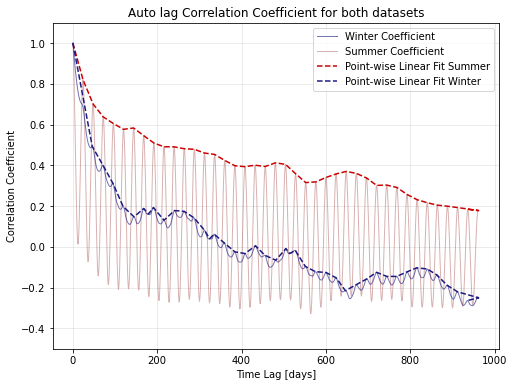

In [912]:
# local extrema for the winter data appear to occur at [0,1] and [23,0.7],
# while for the summer data they are at [0,1] and [24,0.82]:

# the equations of these two lines gives us:
p1w = [0,1]; p2w = [23,0.708]; p1s = [0,1]; p2s = [24, 0.82]

def line(p1,p2, x):
    y = (p2[1]-p1[1])/(p2[0]-p1[0])*(x-p2[0]) + p2[1]
    return y
x_lag = np.linspace(0,40)

winter_line = line(p1w,p2w,x_lag)
summer_line = line(p1s,p2s,x_lag)

# plots em all: 

# plots the lag correlation data:
ff, (ax5) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)
# just plot positive time lags:
ax5.plot(lag_data_w[0], (lag_w_eff),color=[0.1,0.1,0.5], linewidth=1, label="Winter Coefficient", zorder = 10, alpha = 0.6)
ax5.plot(lag_data_s[0], lag_s_eff,color=[0.5,0.,0.], linewidth=1, label="Summer Coefficient", alpha =0.3)

# plotting fits:
ax5.plot(s_max_plot[0], s_max_plot[1], '--', color = [0.8,0.,0.], label = "Point-wise Linear Fit Summer")
ax5.plot(w_max_plot[0], w_max_plot[1], '--', color = [0.1,0.1,0.5],label ="Point-wise Linear Fit Winter")

ax5.set_title("Auto lag Correlation Coefficient for both datasets")
ax5.set_xlabel("Time Lag [days]")
ax5.set_ylabel(r"Correlation Coefficient" )
#ax1.set_xlim(16801-60, 16801+60)
ax5.legend()
ax5.set_ylim(-0.5,1.1)
ax5.grid(True,alpha=0.3)

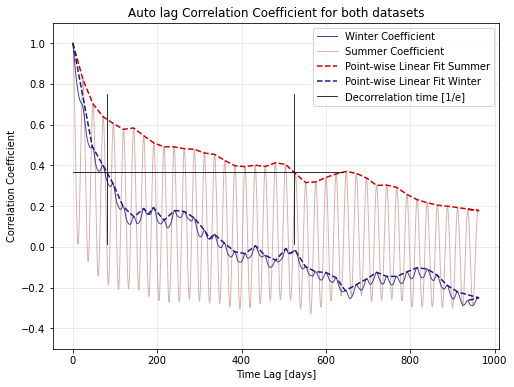

In [949]:
# plots the lag correlation data:
ff, (ax5) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)
# just plot positive time lags:
ax5.plot(lag_data_w[0], (lag_w_eff),color=[0.1,0.1,0.5], linewidth=1, label="Winter Coefficient", zorder = 10, alpha = 0.8)
ax5.plot(lag_data_s[0], lag_s_eff,color=[0.5,0.,0.], linewidth=1, label="Summer Coefficient", alpha =0.3)

# plotting fits:
ax5.plot(s_max_plot[0], s_max_plot[1], '--', color = [0.8,0.,0.], label = "Point-wise Linear Fit Summer")
ax5.plot(w_max_plot[0], w_max_plot[1], '--', color = [0.1,0.1,0.5],label ="Point-wise Linear Fit Winter")

# plots lines to show 1/e:

ax5.axhline(1/np.exp(1),0.045, 0.65, color='k', linewidth=0.8, label="Decorrelation time [1/e]")
plt.axvline(80, 0.32,0.78,color='k', linewidth=0.8)
plt.axvline(525, 0.32,0.78,color='k', linewidth=0.8)

ax5.set_title("Auto lag Correlation Coefficient for both datasets")
ax5.set_xlabel("Time Lag [days]")
ax5.set_ylabel(r"Correlation Coefficient" )
#ax1.set_xlim(16801-60, 16801+60)
ax5.legend()
ax5.set_ylim(-0.5,1.1)
ax5.grid(True,alpha=0.3)

#### Compare the 2 results for rT T (τ ). Are they different? Why? What can you learn from this comparison about local temperature patterns in fall-winter vs. summer.

The two lag correlation coefficents are significantly different from each other. Similarly, the decorrelation times between them almost differ by a factor of 7. Both lagsexhibit some periodic behaviour while the summer coefficient displays quite notable periodicity throughout the function. As expected, both functions begin at a value of 1, perfectly correlated. The Winter coefficient shows small periodicity in amplitude but with a very similar period to that of the summer data. The period of oscillation in both functions is near 24 hours which makes a lot of sense. Within daily cycles we expect cyclical increases and decreases in temperature which is found in both curves. What is interesting, is the drastic difference in amplitude between them. Summer temperatures in the day and night seem to vary greatly, emphasizing the change in daily correlations. Conversely, this suggests that winter temperatures remain (somewhat) more consistent across days. That being said, the envelope of the summer coefficient drops off much more slowly than for that of the winter coefficient. The decorrelation time for the winter data is about 80 hours (or 3.33 days) while the summer correlation within the maximal amplitude envelope is near 525 hours (or 21.9 days). This suggests that winter temperatures are volatile within half of a week duration while summer temperatures are consistentfor much longer, nearly monthly. What is also interesting is that the winter coefficient drops below zero and becomes increasingly negative for much of the interval after a lag of 400 of so hours. This correspends to lags of about 16 days or half a month. This may suggest a level of symmetry in the winter season from November to January meaning that trends in temperature may be similar on either side of centre for this interval.  


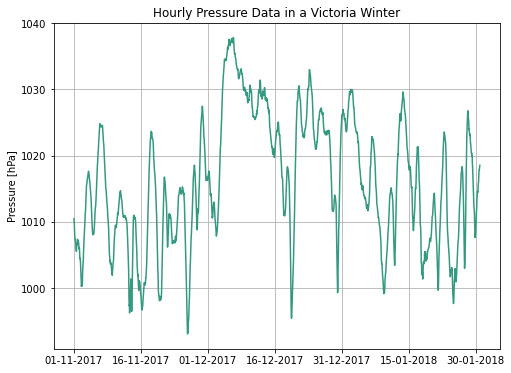

In [950]:
# we now need to repeat the above procedure for the pressure data.
# this is simply a task of reproducing previous used code:

# winter hourly pressure data:
ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)

# plots the hourly data:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax1.plot(winter_test + 16801, winter_p, color=[0.2,0.6,0.5])
ax1.set_title("Hourly Pressure Data in a Victoria Winter")
#ax1.set_xlabel("Random Numbers")
ax1.set_ylabel(r"Pressure [hPa]" )
#ax1.set_ylim(9, 10)
ax1.grid(True)



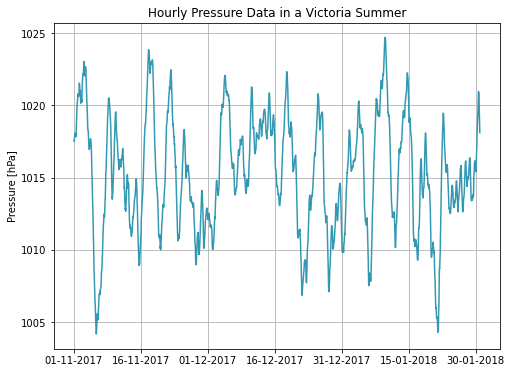

In [951]:
# summer hourly pressure data:
ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)

# plots the hourly data:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax1.plot(winter_test + 16801, summer_p, color=[0.2,0.6,0.7])
ax1.set_title("Hourly Pressure Data in a Victoria Summer")
#ax1.set_xlabel("Random Numbers")
ax1.set_ylabel(r"Pressure [hPa]" )
#ax1.set_ylim(9, 10)
ax1.grid(True)


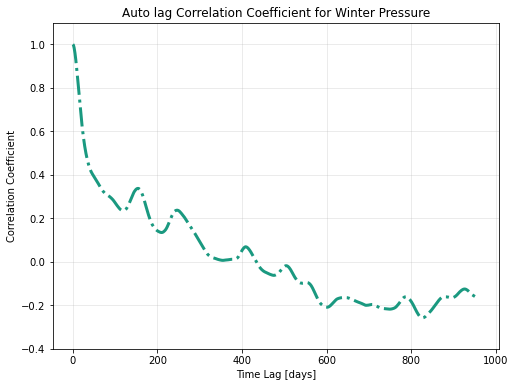

In [952]:
# now need to calculate and plot r_TT for lags < 40 days:

# lags and resulting correlation coefficient for winter pressure:
lag_data_wp = lag_correlation(winter_p, 960)
lag_wp_eff = lag_data_wp[1][961:]

# plots the lag correlation data:
ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)
# just plot positive time lags:
ax1.plot(lag_data_wp[0], lag_wp_eff, '-.',color=[0.1,0.6,0.5], linewidth=3)
ax1.set_title("Auto lag Correlation Coefficient for Winter Pressure")
ax1.set_xlabel("Time Lag [days]")
ax1.set_ylabel(r"Correlation Coefficient" )
#ax1.set_xlim(16801-60, 16801+60)
ax1.set_ylim(-0.4,1.1)
ax1.grid(True,alpha=0.3)

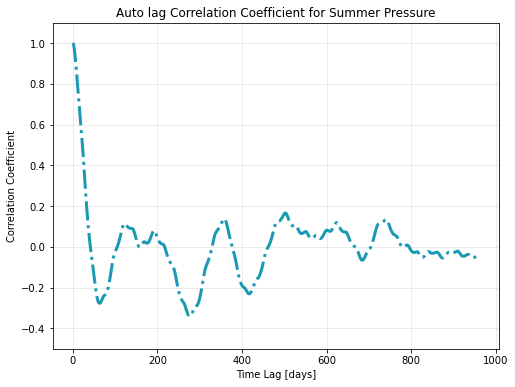

In [953]:
# now need to calculate and plot r_TT for lags < 40 days:

# lags and resulting correlation coefficient for summer pressure:
lag_data_sp = lag_correlation(summer_p, 960)
lag_sp_eff = lag_data_sp[1][961:]

# plots the lag correlation data:
ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)
# just plot positive time lags:
ax1.plot(lag_data_sp[0], lag_sp_eff, '-.',color=[0.1,0.6,0.7], linewidth=3)
ax1.set_title("Auto lag Correlation Coefficient for Summer Pressure")
ax1.set_xlabel("Time Lag [days]")
ax1.set_ylabel(r"Correlation Coefficient" )
#ax1.set_xlim(16801-60, 16801+60)
ax1.set_ylim(-0.5,1.1)
ax1.grid(True,alpha=0.3)

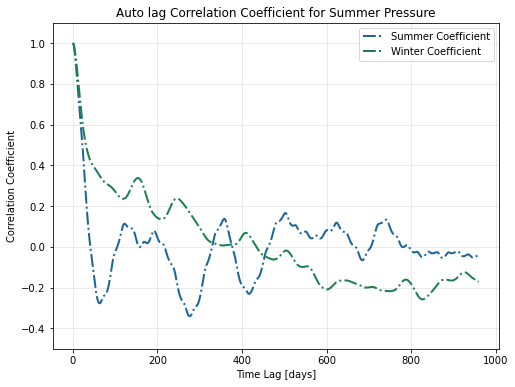

In [954]:
# now need to calculate and plot r_TT for lags < 40 days:

# lags and resulting correlation coefficient for summer pressure:
lag_data_sp = lag_correlation(summer_p, 960)
lag_sp_eff = lag_data_sp[1][961:]

# plots the lag correlation data:
ff, (ax1) = plt.subplots(1, 1)
ff.set_figwidth(8)
ff.set_figheight(6)
# just plot positive time lags:
ax1.plot(lag_data_sp[0], lag_sp_eff, '-.',color=[0.1,0.4,0.6], linewidth=2, label="Summer Coefficient")
ax1.plot(lag_data_wp[0], lag_wp_eff, '-.',color=[0.1,0.5,0.3], linewidth=2, label="Winter Coefficient")
ax1.set_title("Auto lag Correlation Coefficient for Summer Pressure")
ax1.set_xlabel("Time Lag [days]")
ax1.set_ylabel(r"Correlation Coefficient" )
ax1.legend()
#ax1.set_xlim(16801-60, 16801+60)
ax1.set_ylim(-0.5,1.1)
ax1.grid(True,alpha=0.3)

#### What can you learn from this comparison about the forecast period of a skilled prediction of temperature and pressure by a ”dummy forecast”?

The dummy forecast predicted that tomorrow's weather will be the same as today's. We can analyze the four auto-lag correlation coefficient functions from above to check the validity of that statement. The first important thing to consider is the decorrelation time from the temperature data. In winter, this value is only 3.33 days. Right off the bat it is easy to conclude that predictions in a time period larger than this without more data will come up short. For summer, this value is 20 odd days which strengthens the efficacy of the dummy forecast in those months. Another thing to look at is the pressure correlation functions. If we were to proceed with the decorrelation analysis as before, these functions would have very small values on the order of less than 40 hours; the value for the summer decorrelation time would be even smaller. If pressure is barely correlated in ranges of a day or two it makes it increasingly more difficult to make conclusions about future data with only these methods, in the summer even more so. What is even more troubling is the lack of periodicity in both pressure functions. There is not even a semblance of daily cycles when it comes to pressure in either season making it even less likely a dummy forecast would be correct. 

It would be reasonable to predict summer temperatures naively in advance up to a week or two but summer pressures are far to volatile leading to a fairly small forecast period for a dummy forecast. Winter time has a different issue. Pressures are slightly more consistent for up to week long lags in the correlation function when compared to summer. But temperature correlation drops off rapidly and never recovers. In culmination, both summer and winter weather patterns are dynamic for different reasons. A skilled dummy weather forecast that predicts day-to-day identical weather will be reasonably accurate in a 24 hour period for summer temperatures, moderately accurate for winter temperatures and rather poor for pressures in both seasons, moreso in the summer. 







### Question 3. Confidence intervals for minute-resolution and hour-resolution data

Read in the two data sets, hour-resolution and minute-resolution, for the Station ‘Cortes’ (50.0599oN, 235.017o). For this exercise look only at data from 7 August 2017 and 7 August 2019, local time. (Note, times are given in UTC. For August, local time = UTC - 7/24 [days]) .
1. To show that you have picked the correct time intervals, plot the data for the two periods
   with minute and hour resolution data on the same axes. (Use subplots for the two different
   days.)
2. From the hour resolution data set:
   * Calculate the mean temperatures for each day (07/08/2017 and 07/08/2019) and determine with    95% confidence if August 7 was warmer in 2019 than in 2017.
3. Repeat the calculation with the minute resolution data set:
   * Again, determine if August 7 was warmer in 2019 than in 2017 at the 95% confidence
     level.
   * Briefly discuss the results.

In [629]:
# load in the data first:
hourly_temp = np.loadtxt("/Users/benrasmussen/Documents/Phys 411/Data/UVic_weatherdata_temperature_hourly.dat").T
minute_uvic_data = np.loadtxt("/Users/benrasmussen/Documents/Phys 411/Data/UVIcWeatherdata_Minute_2022/Cortes_Tp.dat").T



In [631]:
# organize the data:

hours = hourly_temp[0]
cortes_ht = hourly_temp[2]
cortes_mt = minute_uvic_data[0]


# clean up header data:

cortes_ht = cortes_ht[3:]
cortes_mt = cortes_mt[2:]
hours = hours[3:]

In [657]:
# time parameters:

time_2_7aug17d = 17385 # days
time_2_7aug17m = 25034400 # minutes
time_2_7aug19d = 18115 # days
time_2_7aug19m = 26085600
length_of_daym = 1440 # minutes
length_of_msample = 3461760 # minutes
initial_time = 16801 # days
length_of_dayh = 24 # hours
UTC_change = 7 # hrs

difference_7aug17 = (time_2_7aug17m - initial_time*60*24 + UTC_change*60)   # minutes
difference_7aug19 = (time_2_7aug19m - initial_time*60*24 + UTC_change*60)   # minutes

difference_7aug17_h = (time_2_7aug17m/60 - initial_time*24 + UTC_change)
difference_7aug19_h = (time_2_7aug19m/60 - initial_time*24 + UTC_change)


# final data sets:
aug_717_mt = cortes_mt[int(difference_7aug17):int(difference_7aug17)+length_of_daym]
aug_719_mt = cortes_mt[difference_7aug19:difference_7aug19+length_of_daym]

aug_717_ht = cortes_ht[int(difference_7aug17_h):int(difference_7aug17_h)+length_of_dayh]
aug_719_ht = cortes_ht[int(difference_7aug19_h):int(difference_7aug19_h)+length_of_dayh]

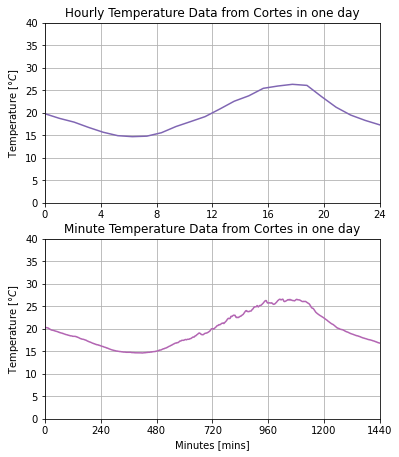

In [694]:
# plots time series:

# plottable time vectors:
hrs = np.linspace(0,24,24)
mins = np.linspace(0,1440,1440)
mins_in_hrs = np.linspace(0,24,1440)

# plots both the minute and hourly data for the single day in Cortes:
# (7 august 2017)
f, (ax2,ax1) = plt.subplots(2, 1)
ff.set_figwidth(8)
ff.set_figheight(6)


# plots the minute data:
ax1.plot(mins,aug_717_mt, color=[0.7,0.4,0.7])
ax1.set_title("Minute Temperature Data from Cortes in one day")
ax1.set_ylabel(r"Temperature [$\degree C$]" )
ax1.set_ylim(0, 40)
ax1.grid(True)
ax1.set_xlim(0,1440)
ax1.set_xticks(range(0,1441,240))
ax1.set_xlabel("Minutes [mins]")

# plots the hourly data:
ax2.plot(hrs,aug_717_ht, color=[0.5,0.4,0.7])
ax2.set_title("Hourly Temperature Data from Cortes in one day")
ax2.set_ylabel(r"Temperature [$\degree C$]" )
ax2.set_ylim(0, 40)
ax2.grid(True)
ax2.set_xlim(0,24)
ax2.set_xticks(range(0,25,4))
plt.subplots_adjust(top=1.5)

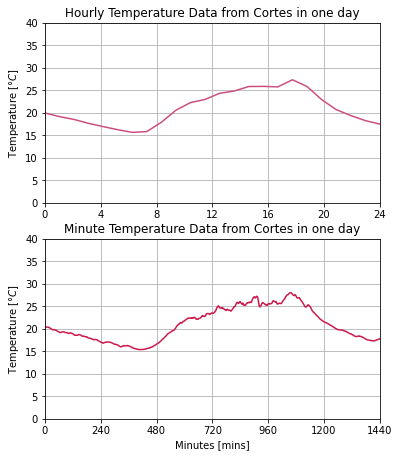

In [695]:
# plots both the minute and hourly data for the single day in Cortes:
# (9 august 2017)
f, (ax2,ax1) = plt.subplots(2, 1)
ff.set_figwidth(8)
ff.set_figheight(6)


# plots the minute data:
ax1.plot(mins,aug_719_mt, color=[0.8,0.1,0.3])
ax1.set_title("Minute Temperature Data from Cortes in one day")
ax1.set_ylabel(r"Temperature [$\degree C$]" )
ax1.set_ylim(0, 40)
ax1.grid(True)
ax1.set_xlim(0,1440)
ax1.set_xticks(range(0,1441,240))
ax1.set_xlabel("Minutes [mins]")

# plots the hourly data:
ax2.plot(hrs,aug_719_ht, color=[0.8,0.3,0.5])
ax2.set_title("Hourly Temperature Data from Cortes in one day")
ax2.set_ylabel(r"Temperature [$\degree C$]" )
ax2.set_ylim(0, 40)
ax2.grid(True)
ax2.set_xlim(0,24)
ax2.set_xticks(range(0,25,4))
plt.subplots_adjust(top=1.5)

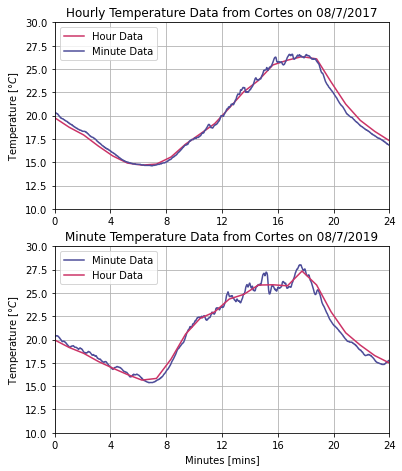

In [722]:
# combined plot for completeness:

f, (ax2,ax1) = plt.subplots(2, 1)
ff.set_figwidth(8)
ff.set_figheight(6)


# plots the minute data:
ax1.plot(mins_in_hrs,aug_719_mt, color=[0.3,0.3,0.6], label="Minute Data")
ax1.plot(hrs,aug_719_ht, color=[0.8,0.2,0.4], label="Hour Data")
ax1.set_title("Minute Temperature Data from Cortes on 08/07/2019")
ax1.set_ylabel(r"Temperature [$\degree C$]" )
ax1.set_ylim(10, 30)
ax1.grid(True)
ax1.set_xlim(0,24)
ax1.set_xticks(range(0,25,4))
ax1.set_xlabel("Minutes [mins]")
ax1.legend()

# plots the hourly data:
ax2.plot(hrs,aug_717_ht, color=[0.8,0.2,0.4], label="Hour Data")
ax2.plot(mins_in_hrs, aug_717_mt, color = [0.3,0.3,0.6], label="Minute Data")
ax2.set_title("Hourly Temperature Data from Cortes on 08/07/2017")
ax2.set_ylabel(r"Temperature [$\degree C$]" )
ax2.set_ylim(10, 30)
ax2.grid(True)
ax2.set_xlim(0,24)
ax2.set_xticks(range(0,25,4))
ax2.legend()

plt.subplots_adjust(top=1.55)

#### Confidence intervals for mean temperature data:

As we do not know $\sigma_T$, we then need to take the standard deviation of the measured subset such that:

$$ s^2_T = \frac{1}{N-1} \sum_{i=1}^N (T_i -\bar{T})^2$$

Where $\bar{T}$ is the mean of the sample and N is the number of realizations in the sample set. $s_T$ will be distributed like a student-t distribution with $n=N-1$ degrees of freedom. Our interval where we can determine a desired degree of confidence then becomes:

$$\mu_T = \bar{T} \pm t_{\alpha/2,n} \frac{s_T}{\sqrt{N}}$$

With $t_{\alpha/2,n} $ as the value of the student-t inverse at the desired confidence interval.

In [746]:
# with the hourly datasets we now want to find the means and the confidence intervals:

# means of the two datasets:

mean_717_ht = 1/(len(aug_717_ht)) * sum(aug_717_ht)  # for completeness
mean_719_ht = np.mean(aug_719_ht)

# now need s_T for each data set:

# for completeness:
std_717_ht = np.sqrt(1/(len(aug_717_ht)-1) * sum([(aug_717_ht[i] - mean_717_ht)**2 for i in range(len(aug_717_ht))]))
std_719_ht = np.std(aug_719_ht)

# also need the student-t multiplicative factor:

t_alpha_ht = sp.stats.t.ppf(1-0.05/2, len(aug_717_ht)-1)  # n=N-1

# and our ranges:

factor_717_ht = t_alpha_ht * std_717_ht / (np.sqrt(len(aug_717_ht)))
factor_719_ht = t_alpha_ht * std_719_ht / (np.sqrt(len(aug_719_ht)))


In [752]:
# now that we have the requisite statistics we can find our confidence intervals:

lower_717_ht = mean_717_ht - factor_717_ht
upper_717_ht = mean_717_ht + factor_717_ht

lower_719_ht = mean_719_ht - factor_719_ht
upper_719_ht = mean_719_ht + factor_719_ht

print(f"The range in the 08/07/2017 hourly data for 95% confidence is: {lower_717_ht:2f} < {mean_717_ht:0.2f} < {upper_717_ht:0.2f}")
print()
print(f"The range in the 08/07/2019 hourly data for 95% confidence is: {lower_719_ht:2f} < {mean_719_ht:0.2f} < {upper_719_ht:0.2f}")
print()

The range in the 08/07/2017 hourly data for 95% confidence is: 18.134822 < 19.75 < 21.36

The range in the 08/07/2019 hourly data for 95% confidence is: 19.395723 < 20.93 < 22.47



The mean of August 7th in 2019 is certainly higher that in 2017, as are the edges of the 95% confidence interval. That being said, the interval of 2019 includes the mean in the 2017 data which means, from a statistical point of view, it is not identically different from that value. Although it can be inferred that the temperature in 2019 was indeed higher for that data set in Cortes, the result for the hourly data is inconclusive as there is too much overlap between the intervals. 

In [757]:
# now we want to repeat the above calculations for the minute data:

# means of the two datasets:

mean_717_mt = np.mean(aug_717_mt) 
mean_719_mt = np.mean(aug_719_mt)

# now need s_T for each data set:

std_717_mt = np.std(aug_717_mt)
std_719_mt = np.std(aug_719_mt)

# also need the student-t multiplicative factor:

t_alpha_mt = sp.stats.t.ppf(1-0.05/2, len(aug_717_mt)-1)  # n=N-1

# and our ranges:

factor_717_mt = t_alpha_mt * std_717_mt / (np.sqrt(len(aug_717_mt)))
factor_719_mt = t_alpha_mt * std_719_mt / (np.sqrt(len(aug_719_mt)))

In [758]:
# now that we have the requisite statistics we can find our confidence intervals:

lower_717_mt = mean_717_mt - factor_717_mt
upper_717_mt = mean_717_mt + factor_717_mt

lower_719_mt = mean_719_mt - factor_719_mt
upper_719_mt = mean_719_mt + factor_719_mt

print(f"The range in the 08/07/2017 hourly data for 95% confidence is: {lower_717_mt:2f} < {mean_717_mt:0.2f} < {upper_717_mt:0.2f}")
print()
print(f"The range in the 08/07/2019 hourly data for 95% confidence is: {lower_719_mt:2f} < {mean_719_mt:0.2f} < {upper_719_mt:0.2f}")
print()

The range in the 08/07/2017 hourly data for 95% confidence is: 19.554253 < 19.75 < 19.94

The range in the 08/07/2019 hourly data for 95% confidence is: 20.740635 < 20.93 < 21.12



The means of both these data sets are indentical to the ones from the hourly datasets, somewhat expectedly. What is much different in the minute data is the size of the interval corresponding to 95% confidence. With the massively increased number of realizations, the uncertainty in the sample mean is reduced significantly from the hourly data. With this in mind, when we compare the whole intervals from 2017 to 2019, not only is the mean temperature of August 7th 2017 not included in the 2019 interval, neither is the upper bound. The mean temperature of that date in 2019 for the minute data is identically different from the mean (and confidence interval) of 2017. This means that with 95% confidence, we can conclude that August 7th 2019 was indeed warmer than the same date two years prior. 